In [21]:
# load the data
import os
import numpy as np
import torch
from torch import nn
from glob import glob
import pandas as pd
from pathlib import Path
from tensorboardX import SummaryWriter
import sklearn
import sklearn.metrics
import sklearn.model_selection
import copy

data_dir = Path("data/")
train_tile_annotations = pd.read_csv(data_dir / "train_input/train_tile_annotations.csv")

def get_features(path, ntiles=1000):
    x = np.load(path)[:,3:]
    # tile features to have 1000 ones
    y = np.tile(x,(ntiles//x.shape[0],1))
    if y.shape[0] < ntiles:
        ncat = ntiles%x.shape[0]
        y = np.concatenate([y, x[:ncat]], axis=0)
    resnet_features = y # of size 1000 x 2048
    return resnet_features

class Dataset():
    def __init__(self):
        self.training_output = pd.read_csv(data_dir / "training_output.csv")
        self.ntiles = 1000

    def __getitem__(self, i):
        x = self.training_output.iloc[i]
        ID, target = x['ID'], x['Target']
        
        # load the pre-computed resnet features
        feat_path = glob(f"data/train_input/resnet_features/ID_{ID:03d}*.npy")[0]
        x = get_features(feat_path, ntiles=self.ntiles)
        resnet_features = torch.from_numpy(x).float()
        
        return resnet_features, target

    def __len__(self):
        return len(self.training_output)

class TestDataset():
    def __init__(self):
        self.test_features_paths = sorted(glob("data/test_input/resnet_features/ID_*.npy"))
        print(f"Test dataset has {len(self.test_features_paths)}")
        self.ntiles=  1000

    def __getitem__(self, i):
        feat_path = self.test_features_paths[i]
        ID = feat_path.split('/')[-1].split('.')[0].replace('ID_','')
        # load the pre-computed resnet features
        x = get_features(feat_path, ntiles=self.ntiles)
        resnet_features = torch.from_numpy(x).float()
        
        return resnet_features, ID

    def __len__(self):
        return len(self.test_features_paths)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        fSz = 2048 # dimension of resnet features
        self.conv1x1 = nn.Conv1d(fSz, 1, kernel_size=1, bias=False)

        self.R = 5
        self.mlp = nn.Sequential(
            nn.Linear(2*self.R, 200),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),
            nn.Linear(200, 100),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),
            nn.Linear(100, 1),
        )
        # TODO: Replace Sigmoid with ReLU

        self.BCELoss = nn.BCEWithLogitsLoss()

    def forward(self, feats, targets=None):
        """
            feats: torch.FloatTensor features of the tiles of size bSz,ntiles, fSz 
        """
        
        # bSz, ntiles, fSz
        feats = feats.transpose(1,2)      # Adapt input for conv
        # bSz, fSz, ntiles
        feats = self.conv1x1(feats)[:,0]  # Feature embedding
        # bSz, ntiles

        # min-max selection
        vals, inds = feats.sort(dim=1)
        minmax_inds = torch.cat([inds[:,:self.R] , inds[:,-self.R:]], dim=1)
        minmax_feats = torch.gather(feats, dim=1, index=minmax_inds)

        logits = self.mlp(minmax_feats)
        # bSz, 1
        probs = torch.sigmoid(logits)

        out = {
            'logits':logits, 'probs':probs,
        }
        if targets is not None:
            # compute loss
            loss = self.BCELoss(logits, targets[:,None].float())
            loss += 0.5 * (self.conv1x1.weight**2).sum() # Add weight decay
            out['loss'] = loss
            
        return out



In [6]:
dset = Dataset()
model_ = Model()


# # TODO: data augmentation ?

def fit_and_score(train_dset, val_dset=None, run=0):
    train_loader = torch.utils.data.DataLoader(train_dset, batch_size=10, shuffle=True, drop_last=True)
    if val_dset is not None:
        val_loader = torch.utils.data.DataLoader(val_dset, batch_size=10, shuffle=False, drop_last=False)

    model = copy.deepcopy(model_).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Train loop
    nepochs = 30

    def validate():
        model.eval()

        all_preds = []
        all_targets = []
        for feats, targets in val_loader:
            all_targets.append(targets.numpy())

            with torch.no_grad():
                out = model(feats.cuda())
            all_preds.append(out['probs'].cpu().numpy())
        all_targets = np.concatenate(all_targets)
        all_preds = np.concatenate(all_preds)
        auc = sklearn.metrics.roc_auc_score(all_targets, all_preds)

        return auc

    writer = SummaryWriter(f'runs/run_{run}')

    iteration = 0
    best_auc = 0
    for epoch in range(nepochs):
        model.train()
        for feats, targets in train_loader:
            feats = feats.cuda()
            targets = targets.cuda()
            out = model(feats, targets=targets)

            optimizer.zero_grad()
            out['loss'].backward()
            optimizer.step()

            writer.add_scalar("Train/loss", out['loss'], iteration)
            iteration += 1

        if val_dset is None:
            continue

        # validate and keep the best at each epoch
        auc = validate()
        writer.add_scalar("Val/AUC", auc, iteration)
        
        if auc > best_auc:
            best_auc = auc
            # save best model
            ckpt = {
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch':epoch,
                'auc':auc,
            }
            torch.save(ckpt, os.path.join(writer.logdir, 'model_best.pth'))
        # print(f"Epoch {epoch}: AUC {auc:0.2f}, best AUC {best_auc:0.2f}")

    if val_dset is None:
        ckpt = {
            'model':model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch':epoch,
        }
        torch.save(ckpt, os.path.join(writer.logdir, 'model_final.pth'))

    return best_auc

In [3]:

num_runs = 10
num_splits = 5

aucs = []
for seed in range(num_runs):
    # create new model
    cv = sklearn.model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True,random_state=seed)

    targets = dset.training_output['Target'].tolist()

    cv_aucs = []
    for i, (train_inds, val_inds) in enumerate(cv.split(dset, y=targets)):
        train_dset = torch.utils.data.Subset(dset, train_inds)
        val_dset = torch.utils.data.Subset(dset, val_inds)

        # train model on train_dset; evaluate on val_dset
        auc = fit_and_score(train_dset, val_dset, run=f'seed_{seed}_cv_{i}')
        print(f"seed: {seed} - CV [{i}/{num_splits}] -  AUC: {auc:0.2f}")
        cv_aucs.append(auc)
    
    # cv_auc = np.array(cv_aucs).mean()
    aucs.append(cv_aucs)

aucs = np.array(aucs)

print("Predicting weak labels using Chowder")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

seed: 0 - CV [0/5] -  AUC: 0.90
seed: 0 - CV [1/5] -  AUC: 0.81
seed: 0 - CV [2/5] -  AUC: 0.55
seed: 0 - CV [3/5] -  AUC: 0.77
seed: 0 - CV [4/5] -  AUC: 0.71
seed: 1 - CV [0/5] -  AUC: 0.62
seed: 1 - CV [1/5] -  AUC: 0.91
seed: 1 - CV [2/5] -  AUC: 0.64
seed: 1 - CV [3/5] -  AUC: 0.62
seed: 1 - CV [4/5] -  AUC: 0.78
seed: 2 - CV [0/5] -  AUC: 0.70
seed: 2 - CV [1/5] -  AUC: 0.62
seed: 2 - CV [2/5] -  AUC: 0.88
seed: 2 - CV [3/5] -  AUC: 0.80
seed: 2 - CV [4/5] -  AUC: 0.75
seed: 3 - CV [0/5] -  AUC: 0.65
seed: 3 - CV [1/5] -  AUC: 0.62
seed: 3 - CV [2/5] -  AUC: 0.89
seed: 3 - CV [3/5] -  AUC: 0.91
seed: 3 - CV [4/5] -  AUC: 0.66
seed: 4 - CV [0/5] -  AUC: 0.65
seed: 4 - CV [1/5] -  AUC: 0.68
seed: 4 - CV [2/5] -  AUC: 0.89
seed: 4 - CV [3/5] -  AUC: 0.64
seed: 4 - CV [4/5] -  AUC: 0.71
seed: 5 - CV [0/5] -  AUC: 0.68
seed: 5 - CV [1/5] -  AUC: 0.78
seed: 5 - CV [2/5] -  AUC: 0.75
seed: 5 - CV [3/5] -  AUC: 0.69
seed: 5 - CV [4/5] -  AUC: 0.64
seed: 6 - CV [0/5] -  AUC: 0.60
seed: 6 

In [22]:
# generate the submission file

# -------------------------------------------------------------------------
# Prediction on the test set

# Train a final model on the full training set
train_dset = dset
label = 'final'
print("Training final model")
_ = fit_and_score(train_dset, val_dset=None, run=label)
model = Model()
ckpt = torch.load(f'runs/run_{label}/model_final.pth')
model.load_state_dict(ckpt['model'])
model = model.cuda().eval()

test_dset = TestDataset()

loader = torch.utils.data.DataLoader(test_dset, batch_size=len(test_dset), shuffle=False)

feats, IDs = iter(loader).next()

# load test features
with torch.no_grad():
    preds_test = model(feats.cuda())['probs'].cpu().numpy()[:,0]

print(preds_test.shape)

# Check that predictions are in [0, 1]
assert np.max(preds_test) <= 1.0
assert np.min(preds_test) >= 0.0

# -------------------------------------------------------------------------
# Write the predictions in a csv file, to export them in the suitable format
# to the data challenge platform
test_output = pd.DataFrame({"ID": IDs, "Target": preds_test})
test_output.set_index("ID", inplace=True)
test_output.to_csv(data_dir / "preds_test_chowder.csv")


Training final model
AUC for model trained on all data 0
Test dataset has 120
(120,)


In [ ]:
# use the annotated tiles from data/train_input/train_tile_annotation.csv to compare tumoral and non tumoral tiles.

In [9]:
import pandas as pd
anno = pd.read_csv("data/train_input/train_tile_annotations.csv", index_col=0)
anno

,Target
ID_387_annotated_tile_0_15_69_30.jpg,0.0
ID_387_annotated_tile_1_15_23_53.jpg,0.0
ID_387_annotated_tile_2_15_58_20.jpg,0.0
ID_387_annotated_tile_3_15_67_12.jpg,0.0
ID_387_annotated_tile_4_15_57_20.jpg,0.0
...,...
ID_035_annotated_tile_861_16_73_121.jpg,1.0
ID_035_annotated_tile_862_16_67_126.jpg,1.0
ID_035_annotated_tile_863_16_24_116.jpg,0.0
ID_035_annotated_tile_864_16_69_119.jpg,0.0


In [10]:
anno['Target'].value_counts()

0.0    9417
1.0     707
Name: Target, dtype: int64

1.0 True


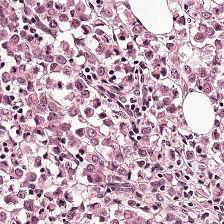

1.0 True


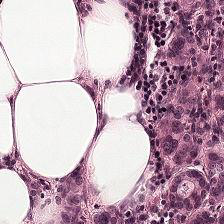

1.0 True


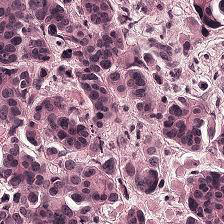

1.0 True


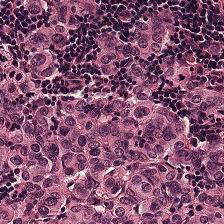

1.0 True


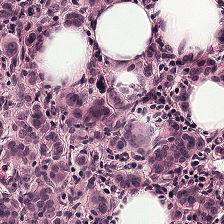

1.0 True


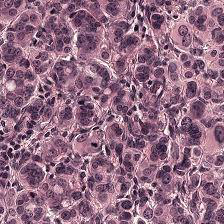

1.0 True


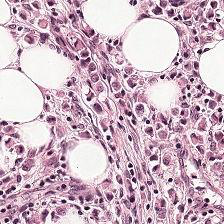

1.0 True


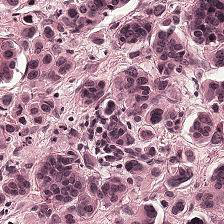

1.0 True


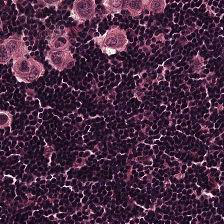

1.0 True


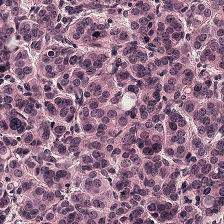

In [27]:
# visualize
import os.path as osp
from PIL import Image
from IPython.display import display

for name, row in anno[anno['Target'] == 1.0].sample(10).iterrows():
    # print(row['Target'], name)
    ID = name[:6]
    file = f"data/train_input/images/{ID}_annotated/{name}"
    print(row['Target'], osp.exists(file))
    im = Image.open(file)
    display(im)


In [1]:
# build a binary classifier on the tiles
import os
import pandas as pd
from PIL import Image
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import random
from sklearn.model_selection import StratifiedKFold

import torch
from torch import nn
from torchvision.models import resnet18

from sklearn.metrics import roc_auc_score
from tensorboardX import SummaryWriter

def get_ID_file_from_name(name, split='train'):
    ID = name[:6]
    file = f"data/train_input/images/{ID}_annotated/{name}"
    return ID, file

class DiscreteRotation:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

class TileDataset():
    def __init__(self, df, transform=None, split='train'):
        df = df.sort_values(by=['Target'])
        self.df = df
        self.transform = transform
        self.split = split

    def __getitem__(self, i):
        x = self.df.iloc[i]
        name = x.name
        target = x['Target']
        ID, file = get_ID_file_from_name(name, split=self.split)
        im = Image.open(file)
        if self.transform is not None:
            im = self.transform(im)
        return im, target, i

    def __len__(self):
        return len(self.df)


In [4]:
anno = pd.read_csv("data/train_input/train_tile_annotations.csv", index_col=0)

seed = 0
num_splits = 10
outdir = "runs/train_binary_classifier/test/"

cv = StratifiedKFold(n_splits=num_splits, shuffle=True,random_state=seed)
for train_inds, val_inds in cv.split(anno, y=anno['Target']):
    batch_size = 64
    nepochs = 100

    # transforms
    normalize = T.Normalize(mean=[0.5972, 0.4646, 0.5658], std=[0.2730, 0.2970, 0.2617])
    train_transform = T.Compose([
            T.RandomResizedCrop(224),
            T.RandomHorizontalFlip(),
            DiscreteRotation([0, 90, -90, 180]),
            T.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0),
            T.ToTensor(),
            # normalize,
        ])
    val_transform = T.Compose([
            T.ToTensor(),
            normalize,
        ])

    train_dset = TileDataset(anno.iloc[train_inds], transform=train_transform)
    val_dset = TileDataset(anno.iloc[val_inds], transform=val_transform)
    print(len(train_dset), len(val_dset))
    

    df = train_dset.df['Target']
    counts = df.value_counts()
    # weight the rare samples so that they are sampled with equal freq as pos samples
    weights = (train_dset.df['Target']*(counts[0]/counts[1]-1)+1)
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size*int(len(train_dset)/batch_size))
    train_loader = torch.utils.data.DataLoader(train_dset, 
                batch_size=batch_size, sampler=sampler, num_workers=8)
    val_loader = torch.utils.data.DataLoader(train_dset, 
                batch_size=batch_size, shuffle=False, num_workers=8)
    break


    # network
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(512, 1)
    model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30)
    def validate():
        all_preds = []
        all_targets= []

        model.eval()
        for i, (ims, targets, inds) in enumerate(val_loader):
            ims = ims.cuda()
            
            with torch.no_grad():
                preds = model(ims).cpu()
            all_preds.append(preds)
            all_targets.append(targets)
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)

        auc = roc_auc_score(all_targets.numpy(), all_preds.numpy())
        return auc

    writer = SummaryWriter(outdir)
    best_auc = 0
    iteration = 0
    for epoch in range(nepochs):
        model.train()
        for i, (ims, targets, inds) in enumerate(train_loader):
            ims = ims.cuda()
            targets = targets.cuda()
            preds = model(ims)

            loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if iteration % 10 == 0:
                writer.add_scalar("Train/loss", loss.item(), iteration)
            iteration += 1

        auc = validate()
        
        writer.add_scalar("Val/auc", auc, epoch)
        writer.add_scalar("Train/lr", optimizer.param_groups[0]['lr'], epoch)
        scheduler.step()
        if auc > best_auc:
            best_auc = auc

            ckpt = {
                'model':model.state_dict(),
                'optimizer':optimizer.state_dict(),
                'scheduler':scheduler.state_dict(),
                'epoch':epoch,
                'iteration':iteration,
                'auc':auc,
            }
            torch.save(ckpt, os.path.join(writer.logdir, 'model_best.pth'))

            
    break


9111 1013


In [5]:
len(train_loader)

142

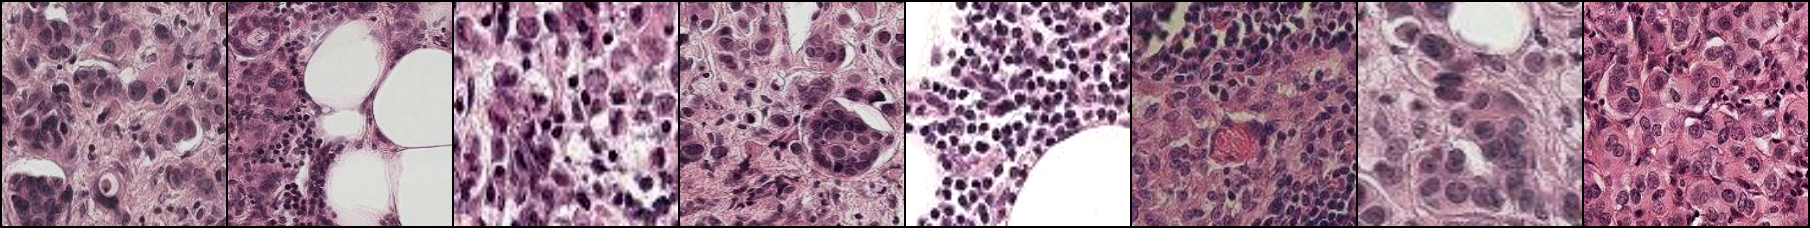

In [134]:
ims.size()
from torchvision.utils import make_grid
im = make_grid(ims[:8])
TF.to_pil_image(im)

In [105]:
whole_dset = TileDataset(anno)

In [106]:
len(whole_dset)

10124

In [13]:
# use binary classifier to classify all the tiles of each slide
from glob import glob
slides = glob("data/train_input/images/ID*")
non_annotated_slides = [s for s in slides if '_annotated' not in s]
len(slides), len(non_annotated_slides)

for slide in non_annotated_slides:
    im_paths = glob(slide+'/*.jpg')
    print(im_paths[:5])
    break

['data/train_input/images/ID_298/ID_298_tile_633_16_82_208.jpg', 'data/train_input/images/ID_298/ID_298_tile_118_16_74_156.jpg', 'data/train_input/images/ID_298/ID_298_tile_450_16_73_165.jpg', 'data/train_input/images/ID_298/ID_298_tile_608_16_40_163.jpg', 'data/train_input/images/ID_298/ID_298_tile_274_16_44_160.jpg']


In [14]:
anno

,Target
ID_387_annotated_tile_0_15_69_30.jpg,0.0
ID_387_annotated_tile_1_15_23_53.jpg,0.0
ID_387_annotated_tile_2_15_58_20.jpg,0.0
ID_387_annotated_tile_3_15_67_12.jpg,0.0
ID_387_annotated_tile_4_15_57_20.jpg,0.0
...,...
ID_035_annotated_tile_861_16_73_121.jpg,1.0
ID_035_annotated_tile_862_16_67_126.jpg,1.0
ID_035_annotated_tile_863_16_24_116.jpg,0.0
ID_035_annotated_tile_864_16_69_119.jpg,0.0


In [ ]:

# train dataset can be augmented with other samples from benign slides !!!
